## Project DSI 311 

## Data understaning
ชื่อชุดข้อมูล : Chest X-Ray Images (Pneumonia)  
แหล่งที่มา : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia  
ชุดข้อมูลนี้เป็นโจทย์เกี่ยวกับ Classification การจำแนกประเภทปอดอักเสบและปอดปกติ ซึ่งเหมาะกับ ML Task ที่ได้รับ

ชุดข้อมูลนี้ประกอบด้วยภาพเอกซเรย์ทรวงอกเด็กจำนวน 5,863 ภาพ แบ่งออกเป็นสองประเภทคือ Pneumonia และ Normal ซึ่งภายในประกอบด้วยโฟลเดอร์ย่อยตามหมวดหมู่ของภาพ ภาพทั้งหมดถูกรวบรวมจากผู้ป่วยเด็กอายุ 1–5 ปี ที่เข้ารับการตรวจรักษาตามปกติที่ Guangzhou Women and Children’s Medical Center เมืองกวางโจว ประเทศจีน ก่อนนำมาใช้ ภาพถูกตรวจสอบคุณภาพและคัดทิ้งภาพที่ไม่ชัดเจนหรือใช้งานไม่ได้ จากนั้นแพทย์ผู้เชี่ยวชาญสองท่านร่วมกันให้การวินิจฉัยเพื่อกำหนดฉลากของภาพ   

ข้อมูลที่เตรียมให้  
train = 5,216  
test = 624  
val = 16  
  
เป้าหมายคือ ทำนายโรคปอดอักเสบและปอดที่เป็นปกติ  
0 = ปอดปกติ  
1 = ปอดอักเสบ  


## Library

In [37]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import imagehash
from PIL import Image
from tqdm import tqdm
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split

## kaggle (Load data)

In [ ]:
# with open(".env") as f:
#     for line in f:
#         key, val = line.strip().split("=")
#         os.environ[key] = val

# # print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# # print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [ ]:
# !mkdir -p Data
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p Data

In [ ]:
# with zipfile.ZipFile("Data/chest-xray-pneumonia.zip", "r") as zip_ref:
#     zip_ref.extractall("Data/")

## Data Preparation & Exploratory data analysis   


## 1) Pull data from folder
ดึงข้อมูลภาพจากโฟลเดอร์เก็บไฟล์ทั้งหมดไว้ใน DataFrame

In [39]:
def make_dataframe(base_dir):
    filepaths = []
    labels = []

    for split in ["train", "val", "test"]:
        for label_dir in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(base_dir, split, label_dir)
            for filename in os.listdir(path):
                filepaths.append(os.path.join(path, filename))
                labels.append(0 if label_dir == "NORMAL" else 1)

    df = pd.DataFrame({
        "filepath": filepaths,
        "label": labels
    })
    return df

base_dir = "Data/chest_xray" # Your path
df_all = make_dataframe(base_dir)
print(len(df_all))
df_all['label'].value_counts()

5856


label
1    4273
0    1583
Name: count, dtype: int64

ข้อมูลมีทั้งหมด 5856 ภาพ  
ภาพที่เป็นโรคปอดอักเสบมีทั้งหมด 4273 ภาพ  
ภาพที่เป็นโรคปอดปกติมีทั้งหมด 1583 ภาพ  


## 2) Image size
ตรวจสอบขนาดรูป (width × height) ของภาพ X-ray ทุกภาพใน DataFrame เพื่อดูว่าภาพมีขนาดเท่ากันหรือไม่ และดูว่ามีขนาดรูปภาพที่ผิดปกติหรือไม่

In [40]:
widths = []
heights = []

for path in tqdm(df_all["filepath"], desc="Checking image sizes"):
    try:
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        widths.append(None)
        heights.append(None)

df_all["width"] = widths
df_all["height"] = heights

print("Image Size Summary (pixels)")
display(df_all[["width", "height"]].describe().round(1))


Checking image sizes: 100%|██████████| 5856/5856 [00:02<00:00, 2728.06it/s]

Image Size Summary (pixels)


width  height
count  5856.0  5856.0
mean   1327.9   970.7
std     363.5   383.4
min     384.0   127.0
25%    1056.0   688.0
50%    1281.0   888.0
75%    1560.0  1187.0
max    2916.0  2713.0

Most common image sizes:
Distribution โดยรวม


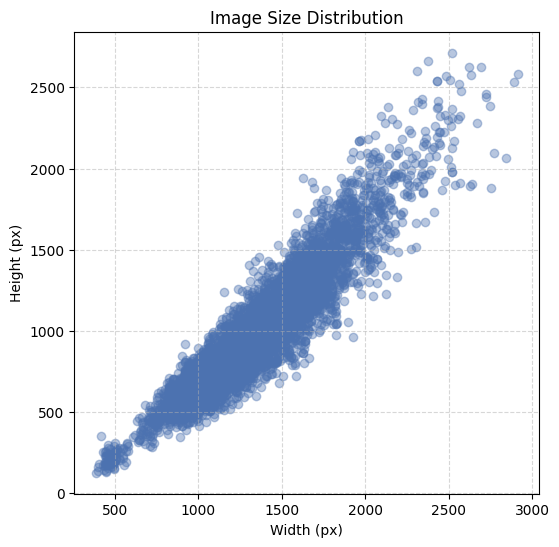

In [41]:
mode_size = df_all.groupby(["width", "height"]).size().reset_index(name="count").sort_values("count", ascending=False)
print("Most common image sizes:")
# display(mode_size.head())

print("Distribution โดยรวม")
plt.figure(figsize=(6,6))
plt.scatter(df_all["width"], df_all["height"], alpha=0.4, color="#4C72B0")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Size Distribution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


จากกราฟจะเห็นได้ว่า Width, Height ที่ช่วง 0 - 500 มีข้อมูลเกาะกลุ่มกันจึงทำการสำรวจเพิ่มเติมว่า ภาพที่มีความสูงความกว้างที่น้อยมีภาพเป็นอย่างไร

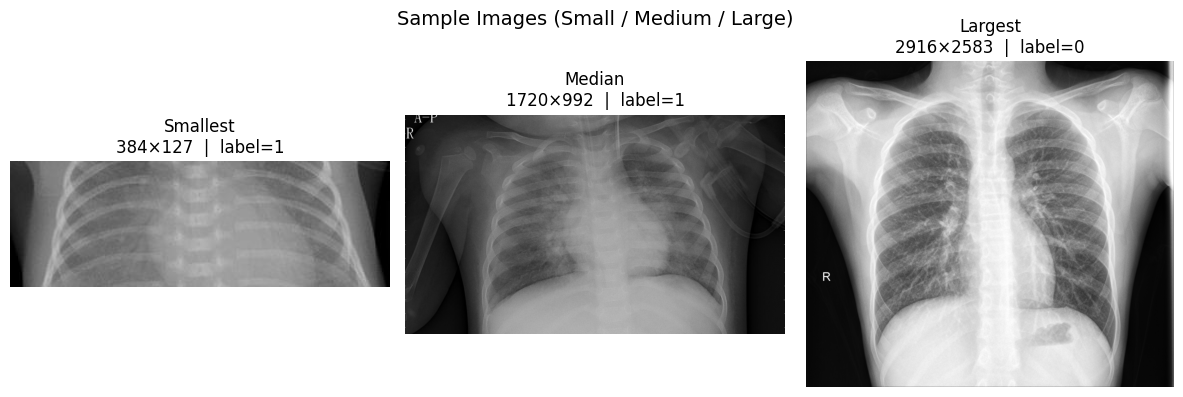

In [42]:
smallest = df_all.sort_values(by=["width", "height"]).iloc[0]
median = df_all.iloc[len(df_all)//2]
largest = df_all.sort_values(by=["width", "height"], ascending=False).iloc[0]

samples = [("Smallest", smallest), ("Median", median), ("Largest", largest)]

plt.figure(figsize=(12,4))

for i, (title, row) in enumerate(samples):
    plt.subplot(1, 3, i+1)
    img = Image.open(row["filepath"])
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}\n{row['width']}×{row['height']}  |  label={row['label']}")
    plt.axis("off")

plt.suptitle("Sample Images (Small / Medium / Large)", fontsize=14)
plt.tight_layout()
plt.show()

เมื่อได้สำรวจขนาดเล็ก กลาง และใหญ่แล้วพบว่า ภาพที่เป็นขนาดกลางและเล็กเหมือนจะเป็นภาพที่ทำการ Crop มาในขั้นตอนถัดไปจะดูว่าแล้วภาพที่เป็นขนาดเล็กมีภาพลักษณ์เป็นอย่างไรบ้างเพื่อตัดสินใจว่าจะทำการ ลบหรือไม่

พบภาพที่ความสูง < 300 px ทั้งหมด 76 ภาพ


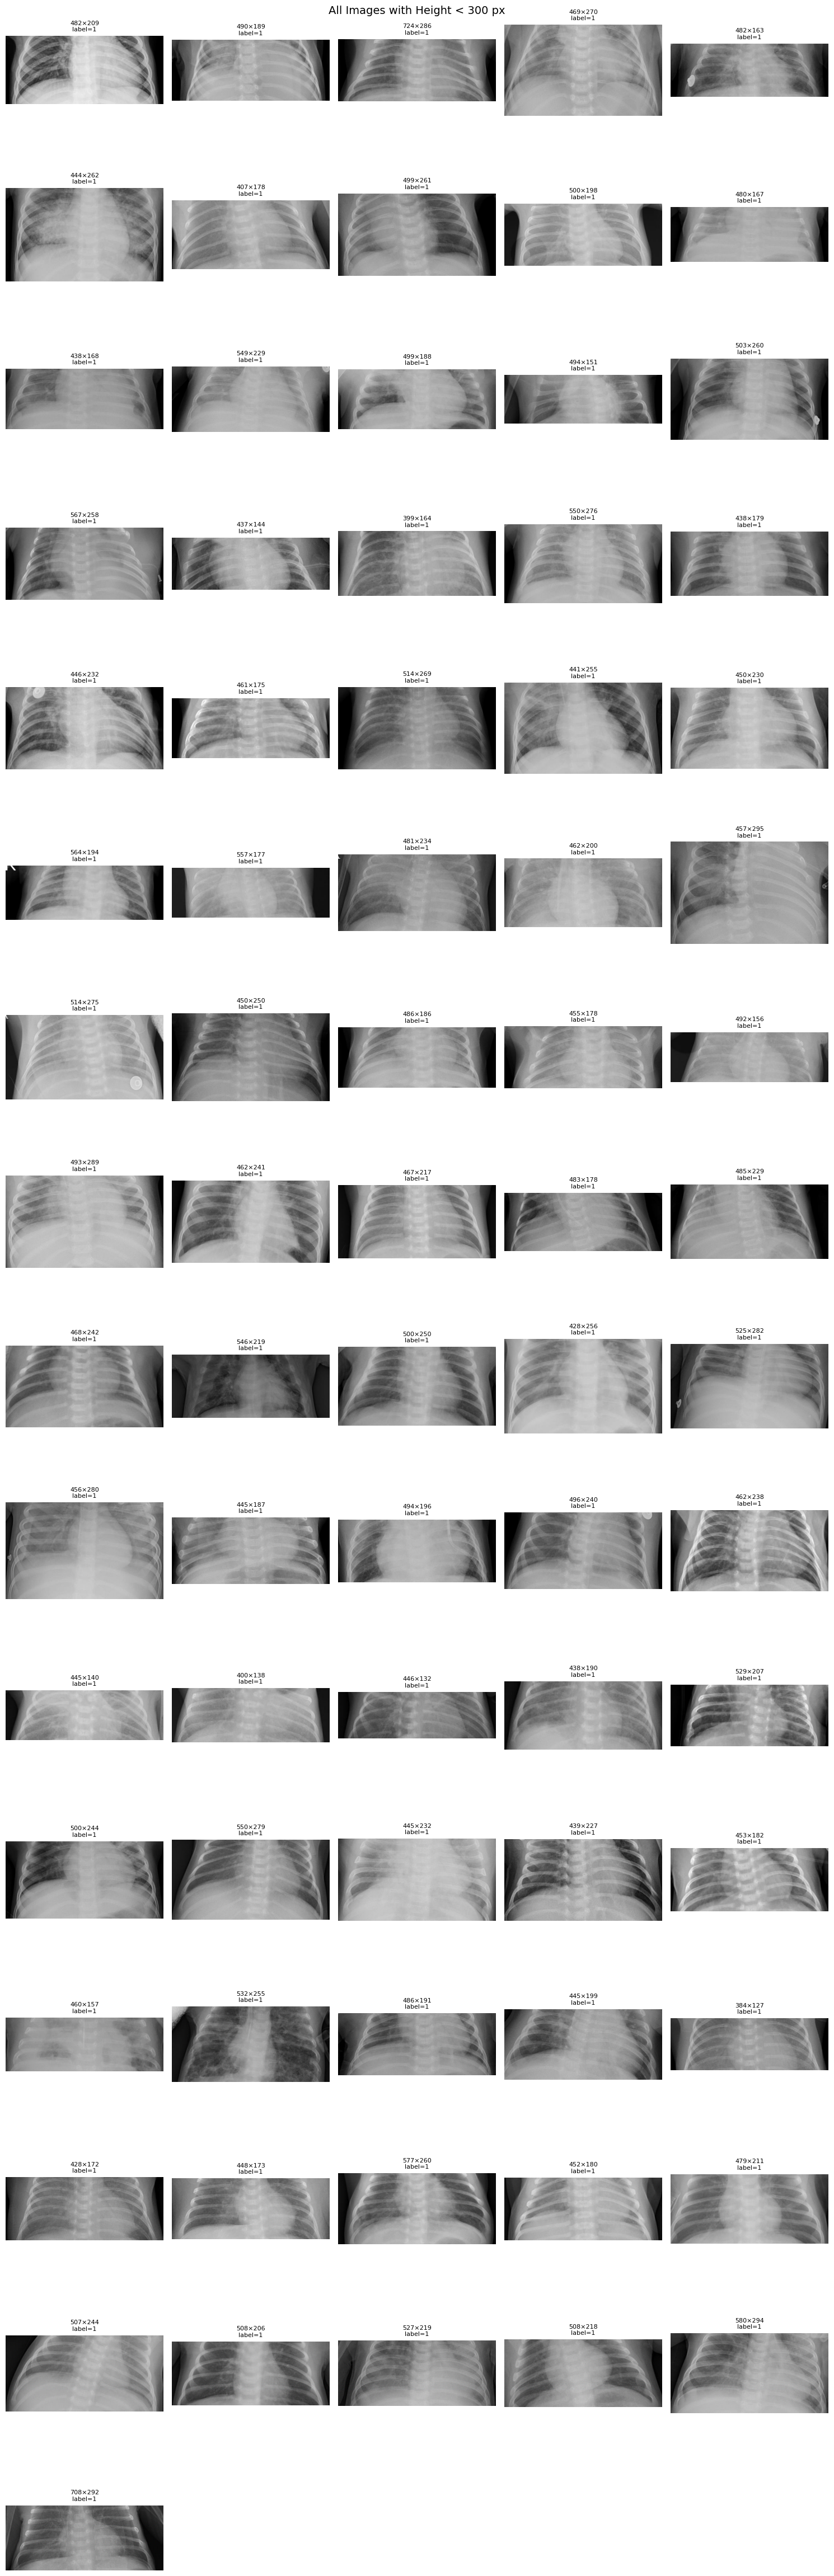

In [26]:
small_imgs = df_all[df_all["height"] < 300]

print(f"พบภาพที่ความสูง < 300 px ทั้งหมด {len(small_imgs)} ภาพ")
n = len(small_imgs)
cols = 5
rows = (n // cols) + 1

plt.figure(figsize=(15, 3 * rows))
for i, (_, row) in enumerate(small_imgs.iterrows()):
    plt.subplot(rows, cols, i+1)
    try:
        img = Image.open(row["filepath"])
        plt.imshow(img, cmap="gray")
        plt.title(f"{row['width']}×{row['height']}\nlabel={row['label']}", fontsize=8)
        plt.axis("off")
    except Exception as e:
        plt.text(0.5, 0.5, "Error", ha="center", va="center")
        plt.axis("off")

plt.suptitle("All Images with Height < 300 px", fontsize=14)
plt.tight_layout()
plt.show()


หลังจากที่ได้สำรวจภาพที่เหมือนจะโดน Crop พบว่าภาพที่ Crop มีประมาณ 76 ภาพในบริเวณช่วงปอด ซึ่งก็ยังคงความสำคัญของภาพไว้อยู่เพราะว่า โรคปอดอักเสบจะมี pattern ในช่วงอกดังนั้นอาจจะไม่จำเป็นต้องตัดออก

## 3) check duplicate image

In [43]:
def compute_phash(path):
    try:
        img = Image.open(path)
        return str(imagehash.phash(img))
    except:
        return None

df_all["phash"] = [
    compute_phash(fp.replace("\\", "/")) for fp in tqdm(df_all["filepath"])
]
df_all


100%|██████████| 5856/5856 [00:36<00:00, 159.00it/s]


filepath  label  width  height  \
0        Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg      0   2090    1858   
1        Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg      0   1422    1152   
2        Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg      0   1810    1434   
3        Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg      0   1618    1279   
4        Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg      0   1600    1125   
...                                                 ...    ...    ...     ...   
5851  Data/chest_xray\test\PNEUMONIA\person96_bacter...      1   1120     856   
5852  Data/chest_xray\test\PNEUMONIA\person96_bacter...      1   1064     856   
5853  Data/chest_xray\test\PNEUMONIA\person97_bacter...      1   1400    1024   
5854  Data/chest_xray\test\PNEUMONIA\person99_bacter...      1   1264    1016   
5855  Data/chest_xray\test\PNEUMONIA\person99_bacter...      1   1704    1122   

                 phash  
0     8129ca38795979cf  
1     c06cc73ecc4f2dc1  
2     912fc74b98c93b92  
3     d07ac61a99ed3c94  
4     907ce73ead0f3824  
...                ...  
5851  946aeb3a0b1a19cf  
5852  946aaf1e011b78ed  
5853  913b4254545f7a5b  
5854  dd28e31f591d5c48  
5855  913def3e4b1b0849  

[5856 rows x 5 columns]

In [44]:
dup_df = df_all[df_all.duplicated("phash", keep='first')].copy()
dup_df = dup_df.sort_values("phash").reset_index(drop=True)


print("จำนวนภาพที่ซ้ำทั้งหมด:", len(dup_df))

จำนวนภาพที่ซ้ำทั้งหมด: 32


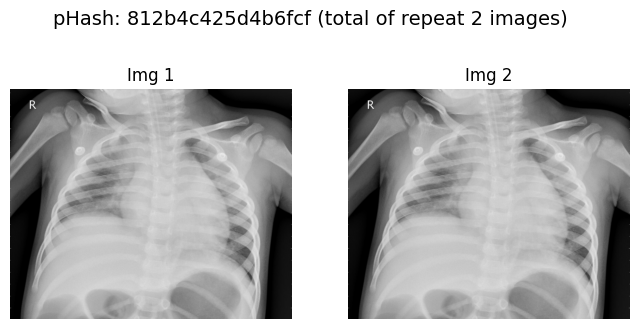

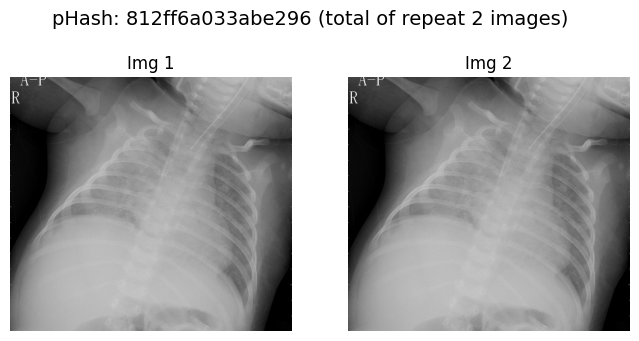

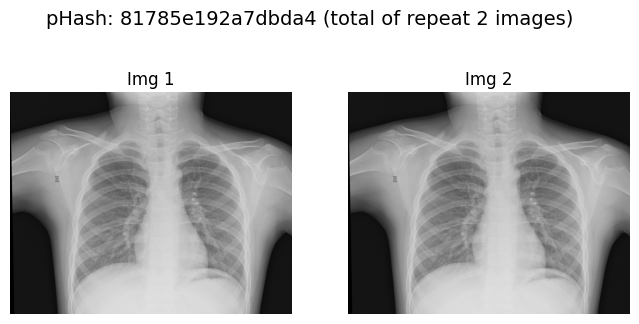

In [29]:
dup_df = df_all[df_all.duplicated("phash", keep=False)].copy()
dup_df = dup_df.sort_values("phash").reset_index(drop=True)
groups = dup_df.groupby("phash")["filepath"].apply(list)
first3 = list(groups.items())[:3]

for ph, filelist in first3:
    n = len(filelist)

    plt.figure(figsize=(4*n, 4))
    plt.suptitle(f"pHash: {ph} (total of repeat {n} images)", fontsize=14)

    for i, fp in enumerate(filelist):
        img = Image.open(fp.replace("\\", "/"))
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Img {i+1}")

    plt.show()


In [45]:
print("จำนวนรูปก่อนลบ:", len(df_all))

df_unique = df_all.drop_duplicates(subset="phash", keep="first").reset_index(drop=True)

print("จำนวนรูปหลังลบ:", len(df_unique))
print("จำนวนที่ถูกลบ:", len(df_all) - len(df_unique))
df_all = df_unique.copy()

จำนวนรูปก่อนลบ: 5856
จำนวนรูปหลังลบ: 5824
จำนวนที่ถูกลบ: 32


ภาพทั้งหมดตอนแรกมีทั้งหมด 5856 ภาพมีการใช้ pHash เพื่อทำการเช็คภาพที่ซ้ำกันผลสรุปคือ  
ผลจาก pHash เจอภาพซ้ำ 32 โดยไม่นับตัวแรกทำการลบภาพที่ซ้ำกันเหลือไว้ตัวแรก  
จำนวนรูปก่อนลบ: 5856  
จำนวนรูปหลังลบ: 5824  
จำนวนที่ถูกลบ: 32  

## 4) check channel of images 
ทำการเช็คว่าภาพทั้งหมดจาก Dataset มีภาพที่เป็น Grayscale และ RGB จำนวนเท่าไหร่ เนื่องจากใช้พิจารณาว่าภาพที่เป็น RGB และ Grayscale จะมองเห็น patternต่างกันอย่างไร และใช้พิจารณในการ input เข้า model

In [47]:
modes = []
for path in tqdm(df_all["filepath"], desc="Checking image color mode"):
    try:
        with Image.open(path) as img:
            modes.append(img.mode)
    except:
        modes.append(None)

df_all["mode"] = modes


print("Image Mode Summary:")
display(df_all["mode"].value_counts())


Checking image color mode: 100%|██████████| 5824/5824 [00:01<00:00, 3291.65it/s]

Image Mode Summary:


mode
L      5541
RGB     283
Name: count, dtype: int64

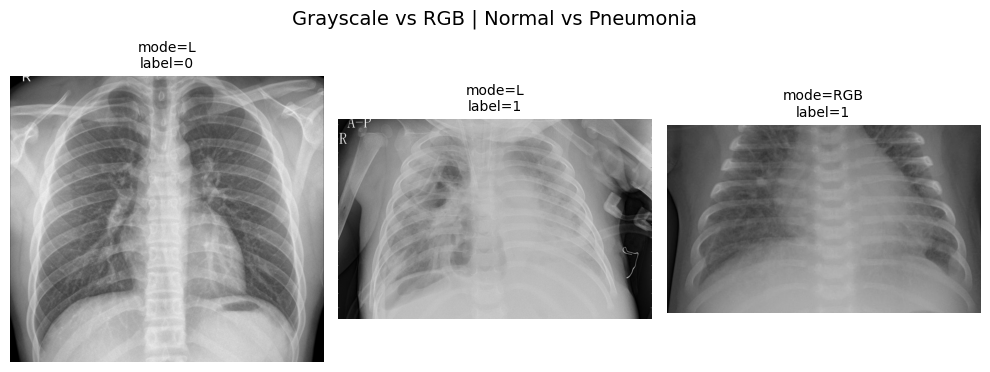

In [48]:
gray_normal     = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 0)]
gray_pneumonia  = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 1)]
rgb_normal      = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 0)]
rgb_pneumonia   = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 1)]

samples = pd.concat([
    gray_normal.sample(min(1, len(gray_normal)), random_state=123),
    gray_pneumonia.sample(min(1, len(gray_pneumonia)), random_state=4236),
    rgb_normal.sample(min(1, len(rgb_normal)), random_state=23412),
    rgb_pneumonia.sample(min(1, len(rgb_pneumonia)), random_state=222122),
])

plt.figure(figsize=(10, 4))
for i, (_, row) in enumerate(samples.iterrows()):
    img = Image.open(row["filepath"])
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray" if row["mode"] == "L" else None)
    plt.title(f"mode={row['mode']}\nlabel={row['label']}", fontsize=10)
    plt.axis("off")

plt.suptitle("Grayscale vs RGB | Normal vs Pneumonia", fontsize=14)
plt.tight_layout()
plt.show()


จากภาพทั้งหมด มี    
Grayscale     5541  
RGB            283     
ภาพ RGB และภาพ Grayscale ก็มีความต่างกันไม่มากและภาพที่เป็น RGB จะมีเฉพาะในฝั่งของเป็นโรคปอดอักเสบ
ดังนั้นจะทำการแปลงเป็น RGB ทั้งหมดเนื่องจากการแปลงจาก Grayscale เป็น RGB ไม่ทำให้ข้อมูลเดิมเสียหายเป็นการเพิ่ม channel ขึ้นมาเป็น 3 channelและเหตุผลสำคัญคือ Model ที่จะนำมา train จะมี Resnet, ViT ซึ่งรองรับเฉพาะ RGB เท่านั้น 

แปลงภาพเป็น RGB ทั้งหมด

In [49]:
df_train = df_all[df_all["filepath"].str.contains("train")]
df_val = df_all[df_all["filepath"].str.contains("val")]
df_test = df_all[df_all["filepath"].str.contains("test")]

print("Updated dataset counts:")
print(f"All:   {len(df_all)}")
print(f"Train: {len(df_train)}")
print(f"Val:   {len(df_val)}")
print(f"Test:  {len(df_test)}")

Updated dataset counts:
All:   5824
Train: 5190
Val:   16
Test:  618


In [50]:
new_dir = "Data/chest_xray_new"
os.makedirs(new_dir, exist_ok=True)

all_paths = pd.concat([df_all, df_train, df_val, df_test])["filepath"].unique()

print(f"กำลังสร้างภาพ RGB ทั้งหมด {len(all_paths)} ไฟล์ ไปยัง: {new_dir}")

for path in tqdm(all_paths, desc="Converting to RGB (new folder)"):
    try:
        rel_name = os.path.basename(path)
        dst_path = os.path.join(new_dir, rel_name)

        with Image.open(path) as img:
            rgb_img = img.convert("RGB")
            rgb_img.save(dst_path)
    except Exception as e:
        print(f"Error converting {path}: {e}")

print("แปลงภาพทั้งหมดเป็น RGB และบันทึกใน Data/chest_xray_new เรียบร้อยแล้ว")


กำลังสร้างภาพ RGB ทั้งหมด 5824 ไฟล์ ไปยัง: Data/chest_xray_new


Converting to RGB (new folder):   0%|          | 0/5824 [00:00<?, ?it/s]

Converting to RGB (new folder): 100%|██████████| 5824/5824 [01:04<00:00, 89.72it/s] 

แปลงภาพทั้งหมดเป็น RGB และบันทึกใน Data/chest_xray_new เรียบร้อยแล้ว


In [51]:
def update_paths(df, new_dir):
    df = df.copy()
    df["filepath"] = df["filepath"].apply(lambda x: os.path.join(new_dir, os.path.basename(x)))
    return df

df_all_new  = update_paths(df_all, "Data/chest_xray_new")
df_train_new = update_paths(df_train, "Data/chest_xray_new")
df_val_new   = update_paths(df_val, "Data/chest_xray_new")
df_test_new  = update_paths(df_test, "Data/chest_xray_new")

df_train_new = df_train_new[~df_train_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_val_new   = df_val_new[~df_val_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_test_new  = df_test_new[~df_test_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)

# print("path ใน df_all, df_train, df_val, df_test")

# print("ตรวจสอบจำนวนไฟล์:")
# print(f"df_all_new  : {len(df_all_new)}")
# print(f"df_train_new: {len(df_train_new)}")
# print(f"df_val_new  : {len(df_val_new)}")
# print(f"df_test_new : {len(df_test_new)}")

## 5) Histogram   
การวิเคราะห์ว่า ภาพที่เป็นปอดอักเสบกับภาพที่เป็นปกติมีลักษณะต่างกันอย่างไร ด้วย Histogram คือการแปลงภาพเป็น grayscale ก่อนแล้วทำการดูว่า มันมีความต่างของ intensy ของสีต่างกันยังไง

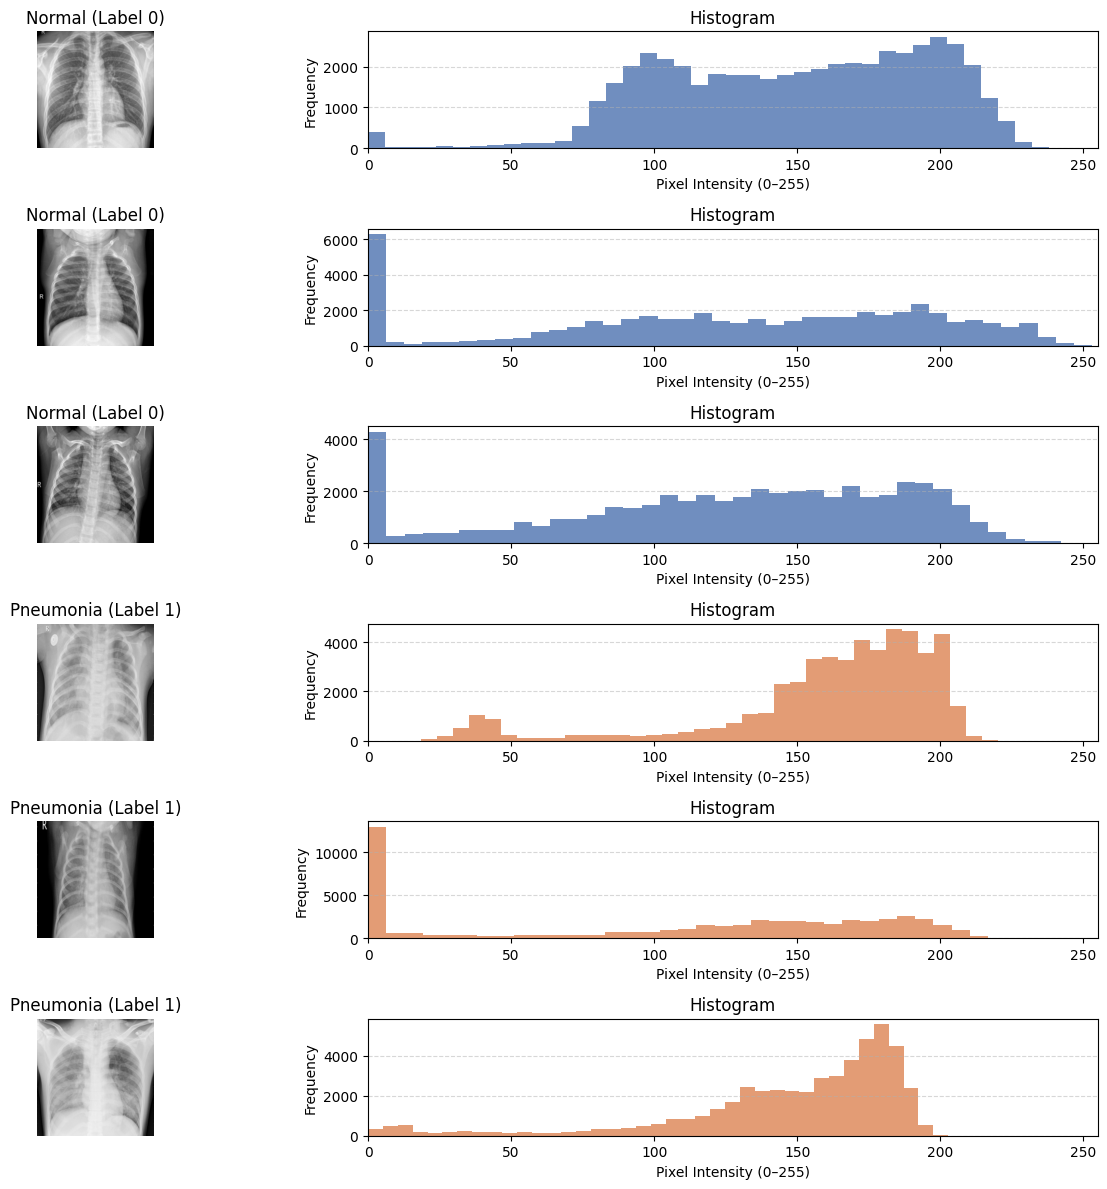

In [56]:
samples_0 = df_all_new[df_all_new["label"] == 0].sample(3, random_state=123)
samples_1 = df_all_new[df_all_new["label"] == 1].sample(3, random_state=23)

resize_size = (224, 224)
plt.figure(figsize=(14, 12))

def plot_image_and_hist(row, index, label_name, color):
    img = Image.open(row["filepath"]).convert("L").resize(resize_size)
    arr = np.array(img)

    plt.subplot(6, 2, 2*index - 1)
    plt.imshow(arr, cmap="gray")
    plt.title(f"{label_name} (Label {row['label']})", fontsize=12)
    plt.axis("off")

    plt.subplot(6, 2, 2*index)
    plt.hist(arr.ravel(), bins=40, color=color, alpha=0.8)
    plt.xlim(0, 255)  
    plt.xlabel("Pixel Intensity (0–255)", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.title("Histogram", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, (_, row) in enumerate(samples_0.iterrows(), start=1):
    plot_image_and_hist(row, i, "Normal", "#4C72B0")

for i, (_, row) in enumerate(samples_1.iterrows(), start=4):
    plot_image_and_hist(row, i, "Pneumonia", "#DD8452")

plt.tight_layout()
plt.show()


จากกราฟจะเห็นว่า ภาพที่ป่วยเป็นปอดอักเสบ Histogram จะมีความเบ้ซ้ายคือ pixel ส่วนมากจะเอนเอี่ยงไปทางช่วง 200 เยอะแสดงถึงมีสีขาวเยอะ
แต่ก็มีบางภาพที่ label 1 คือปอดอักเสบแต่ว่าค่อนข้างมองด้วยตาเปล่ายาก คนทั่วไปอาจจะมองว่าเป็นปกติ เช่น ภาพ 4 มองเหมือนจะเป็นภาพปอดปกติไม่ค่อยมี ฝ้าขาวๆในช่วงปอดแต่ว่าก็เป็น ปอดอักเสบ

**6) Class distribution**

ดูว่า ภาพที่เป็นปอดปกติกับปอดอักเสบ มีจำนวนต่างกันอย่างไรเกิด class imbalance มั้ยและจะจัดการอย่างไร

Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1579  4245   5824          27.1             72.9
Train  1340  3850   5190          25.8             74.2
Val       8     8     16          50.0             50.0
Test    231   387    618          37.4             62.6

<Figure size 800x500 with 0 Axes>

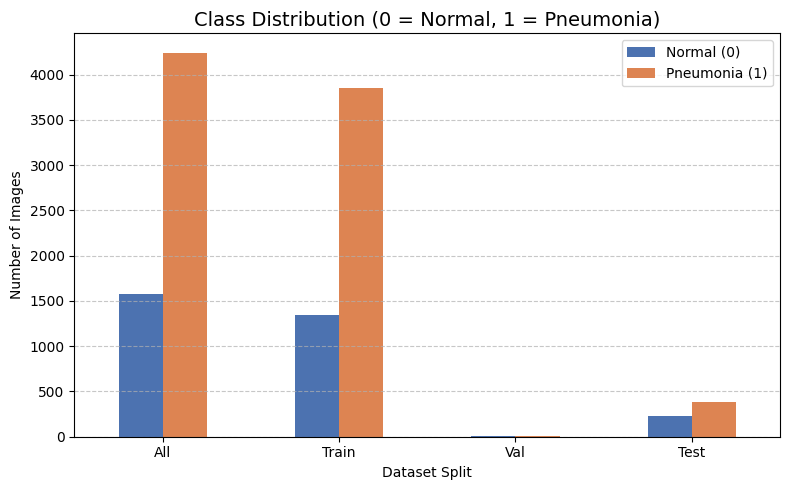

In [107]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


จากกราฟจะเห็นได้ว่าจากข้อมูลที่เขาแบ่งไว้ให้ ในส่วนของ validation, test ค่อนข้างมีจำนวนน้อยมากๆ เมื่อเทียบกับ train ดังนั้นก่อน train model จะมีการเพิ่ม sample ให้เยอะมากขึ้นแต่ยังคง sample ใน validation, test ที่ทางข้อมูล provide อยู่เพราะเป็นข้อมูลที่ทีมแพทย์ label มาให้เป็นการ top up จากเดิม  
 
และข้อมูลค่อนข้าง imbalance ในฝั่งของ Normal มีน้อยกว่า Pneumonia หรือปอดอักเสบมากๆ อาจจจะต้องทำ augmentation เพิ่มฝั่งของ normal ให้มีจำนวนใกล้เคียงกับ Pneumonia

โดยสรุป Preparation & EDA
ข้อมูล เริ่มต้นมี  
Train = 5,216    
Test = 624    
Val = 16    
Total = 5,856  

มีภาพซ้ำกัน 32 ภาพ
และภาพที่เป็น   
Grayscale  = 5,541     
RGB = 283      
 
โดยสรุปภาพหลังจากการทำ Preparation & EDA เหลือภาพทั้งหมด  
Train - 5,190  
Val =  16  
Test =  618  
total = 5,824

## Feature engineering

ทำการทำให้ภาพมีความคมชัดขึ้นตัดภาพส่วนที่เบลอๆ ออกด้วยเทคนิค CLAHE (Contrast Limited Adaptive Histogram Equalization)    
เบื้องหลังของ CLAHE คือ เทคนิคเพิ่มคอนทราสต์เฉพาะที่ ใช้ทำให้รายละเอียดในภาพมืดหรือหม่นดูชัดขึ้น    
เริ่มจากการทำภาพออกเป็นส่วนๆ grid เพราะมีความเชื่อว่าแต่ละมุมของภาพมี ความมืด ความสว่างต่างกัน    
จากนั้น แปลง Contrast แต่ละ block ที่แยก grid ออกมาเพื่อปรับ Contrast ทำให้แต่ละมุมมีการปรับเฉพาะส่วนมากขึ้น    
ดังนั้นมันจึงทำให้ภาพมีความสมจริง เป็น Contrast ที่สว่างจริงๆ มืดจริงๆ ทำให้เห็นรายละเอียดมากขึ้น   

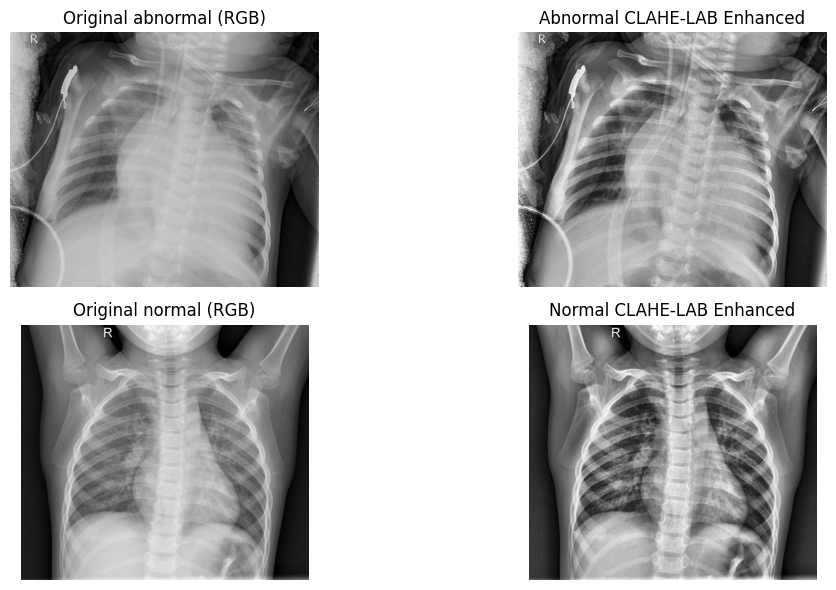

In [59]:
row = df_train_new.loc[1431]
path = row["filepath"].replace("\\", "/")
img = cv2.imread(path)                # BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

row2 = df_train_new.loc[0]
path2 = row2["filepath"].replace("\\", "/")
img2 = cv2.imread(path2)              # BGR
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

def clahe_rgb(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)

    lab2 = cv2.merge((l2, a, b))
    rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    return rgb2

img_clahe = clahe_rgb(img)
img_clahe2 = clahe_rgb(img2)

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original abnormal (RGB)")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_clahe)
plt.title("Abnormal CLAHE-LAB Enhanced")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(img2)
plt.title("Original normal (RGB)")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(img_clahe2)
plt.title("Normal CLAHE-LAB Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()


ทำการแปลงภาพด้วยเทคนิค clahe 

In [ ]:
def clahe_save_new(df, new_dir="Data/chest_xray_clahe"):
    os.makedirs(new_dir, exist_ok=True)

    new_filepaths = []

    for fp in tqdm(df["filepath"], desc="CLAHE converting"):
        path = fp.replace("\\", "/")
        filename = os.path.basename(path)
        dst_path = os.path.join(new_dir, filename)
        img = cv2.imread(path)
        if img is None:
            print(f"Cannot read file: {path}")
            new_filepaths.append(None)
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # LAB + CLAHE
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l2 = clahe.apply(l)

        lab2 = cv2.merge((l2, a, b))
        img_clahe_rgb = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

        img_clahe_bgr = cv2.cvtColor(img_clahe_rgb, cv2.COLOR_RGB2BGR)

        cv2.imwrite(dst_path, img_clahe_bgr)

        new_filepaths.append(dst_path)

    df["filepath_clahe"] = new_filepaths
    return df

df_train_new = clahe_save_new(df_train_new)
df_val_new   = clahe_save_new(df_val_new)
df_test_new  = clahe_save_new(df_test_new)



CLAHE converting: 100%|██████████| 618/618 [00:16<00:00, 38.54it/s]


In [113]:
df_all = make_dataframe(base_dir)
df_train = df_all[df_all["filepath"].str.contains("train")].reset_index(drop=True)
df_val   = df_all[df_all["filepath"].str.contains("val")].reset_index(drop=True)
df_test  = df_all[df_all["filepath"].str.contains("test")].reset_index(drop=True)

def read_file(df,new_dir="Data/chest_xray_clahe"):
    print("chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)")
    df["filepath_clahe"] = [
        os.path.join(new_dir, os.path.basename(fp)) for fp in df["filepath"]
    ]
    return df

df_all_new = read_file(df_all, "Data/chest_xray_clahe")
df_train_new = read_file(df_train, "Data/chest_xray_clahe")
df_val_new   = read_file(df_val,   "Data/chest_xray_clahe")
df_test_new  = read_file(df_test,  "Data/chest_xray_clahe")

chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)
chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)
chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)
chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)


## Data splitting

แบ่งข้อมูลใหมเนื่องจากข้อมูลเดิมมี การแบ่งสัดส่วนที่น้อย
Train = 5,190    
Val =  16    
Test =  618    
total = 5,824  

ทำการแบ่งใหม่ให้สมดุลมากขึ้น โดยการแบ่งแบ่ง val,test เป็นอย่างละ 15%  
จะได้ Val = 870, Test = 870    
โดยที่ จะเป็นการทับของเดิมของ Val, Test เพราะว่าเป็นข้อมูลที่แพทย์ label ไว้ให้แล้วว่าสมเหตุสมผล

Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1583  4273   5856          27.0             73.0
Train  1341  3875   5216          25.7             74.3
Val       8     8     16          50.0             50.0
Test    234   390    624          37.5             62.5

<Figure size 800x500 with 0 Axes>

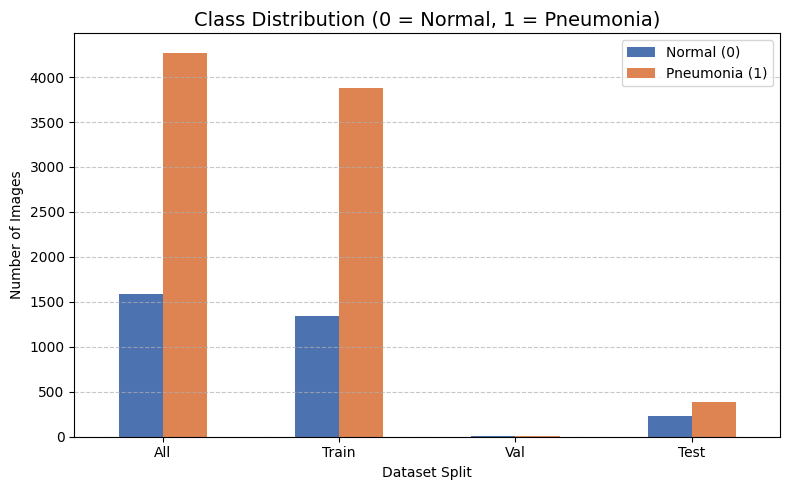

In [115]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [60]:
df_val_old = df_val_new.copy()
df_test_old = df_test_new.copy()
df_train_old = df_train_new.copy()

print("Train:", len(df_train_old))
print("Test:", len(df_test_old))
print("Val:", len(df_val_old))

Train: 5190
Test: 618
Val: 16


In [61]:
target_val = 870
target_test = 870

In [63]:
used_paths = set(df_val_old['filepath']).union(df_test_old['filepath'])
df_remaining = df_train_new[~df_train_new['filepath'].isin(used_paths)]

In [64]:
need_val = target_val - len(df_val_old)
need_test = target_test - len(df_test_old)
need_more = need_val + need_test
print(f"ต้องเพิ่มทั้งหมด {need_more} รูป (โดยเพิ่ม val {need_val} รูป, โดยเพิ่ม test {need_test} รูป)")

ต้องเพิ่มทั้งหมด 1106 รูป (โดยเพิ่ม val 854 รูป, โดยเพิ่ม test 252 รูป)


In [65]:
df_extra, df_train_new = train_test_split(
    df_remaining,
    test_size=(len(df_remaining) - need_more) / len(df_remaining),
    stratify=df_remaining["label"],
    random_state=42
)

df_val_add = df_extra.sample(n=need_val, random_state=42)
df_test_add = df_extra.drop(df_val_add.index).sample(n=need_test, random_state=42)

df_val_new = pd.concat([df_val_old, df_val_add], ignore_index=True)
df_test_new = pd.concat([df_test_old, df_test_add], ignore_index=True)

In [67]:
print("Train:", len(df_train_new))
print("Val:", len(df_val_new))
print("Test:", len(df_test_new))
print("รวมทั้งหมด:", len(df_train_new) + len(df_val_new) + len(df_test_new))

assert len(set(df_val_new['filepath']).intersection(df_test_new['filepath'])) == 0, "มี filepath ซ้ำระหว่าง val/test!"
assert len(set(df_val_new['filepath']).intersection(df_train_new['filepath'])) == 0, "มี filepath ซ้ำระหว่าง val/train!"
assert len(set(df_test_new['filepath']).intersection(df_train_new['filepath'])) == 0, "มี filepath ซ้ำระหว่าง test/train!"

Train: 4084
Val: 870
Test: 870
รวมทั้งหมด: 5824


Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1579  4245   5824          27.1             72.9
Train  1054  3030   4084          25.8             74.2
Val     224   646    870          25.7             74.3
Test    301   569    870          34.6             65.4

<Figure size 800x500 with 0 Axes>

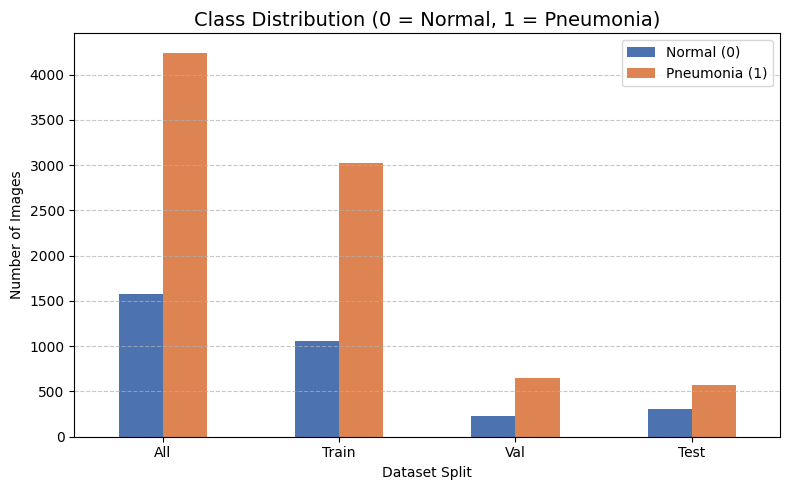

In [68]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


หลังจากที่แบ่งข้อมูลใหม่แล้วจะได้   
Train = 4,084  
Val = 870  
Test = 870  

In [2]:
#สรุปตัวแปรสำหรับเตรียมพร้อม train model
from clean import run_cleaning
from data_split import perform_split
df_train_new, df_val_new, df_test_new = run_cleaning()
df_train_final, df_val_final, df_test_final = perform_split(
    df_train_new,
    df_val_new,
    df_test_new,
    target_val=870,
    target_test=870
)
df_train_new = df_train_final.copy()
df_test_new = df_test_final.copy()
df_val_new = df_val_final.copy()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🚀 START CLEANING PIPELINE                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 0 — Load DataFrame                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Total files loaded: 5856

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (Cache Found)                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_train.csv

[INFO] Images: 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (Cache Found)                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_val.csv

[INFO] Images: 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (Cache Found)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_test.csv

[INFO] Images: 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (RGB Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_train.csv

[INFO] Images (RGB): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (RGB Cache Found)                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_val.csv

[INFO] Images (RGB): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (RGB Cache Found)                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_test.csv

[INFO] Images (RGB): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (CLAHE Cache Found)                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_train.csv

[INFO] Images (CLAHE): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (CLAHE Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_val.csv

[INFO] Images (CLAHE): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (CLAHE Cache Found)                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_test.csv

[INFO] Images (CLAHE): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎉 CLEANING COMPLETE                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Train images: 5190

[INFO] Val images:   16

[INFO] Test images:  618

STEP: Data Split

[INFO] Remaining train images: 5190

[INFO] Need more = 1106 (val 854, test 252)

     SUMMARY     
                 
  Set     Count  
 ─────────────── 
  Train    4084  
  Val       870  
  Test      870  
  Total    5824 

CHECK OVERLAP

✔ No overlaps detected.

## Workflow

## Transforms and Augmentation

ในงาน Image Classification ด้วย PyTorch เราจะใช้ transforms เพื่อจัดการภาพก่อนส่งเข้าโมเดล เช่น Resize, Augmentation, Normalize เป็นต้น   
โดยภาพจะแบ่งออกเป็น 2 กลุ่มหลักคือ RGB และ Grayscale ซึ่งมีขั้นตอนต่างกันเล็กน้อย และแยกอีกทีว่าเป็น NoAug, Aug  

Resize: เนื่องจากโมเดลโครงสร้างส่วนใหญ่ใช้ 224x224 ในการ train ดังนั้นจะต้อง Resize ให้ตรงกับโมเดลที่นำมา Transfer learning  

Feature scaling: 
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

เป็นสถิติ mean และ std ของชุดข้อมูล ImageNet ซึ่งถูกใช้เป็นมาตรฐานสำหรับโมเดลใหญ่ ๆ เช่น ResNet, EfficientNet, ViT  
ทำให้ pixel อยู่ในสเกลใกล้เคียงกัน
ช่วยโมเดล converge เร็วขึ้น
ลดปัญหา gradient แกว่ง
ให้ภาพเข้าโมเดลในรูปแบบเดียวกับตอน pretrain

และในส่วนของ ภาพที่เป็น Grayscale ใช้ mean, std = 0.5 เพราะว่าจาก PyTorch Forum ที่พูดถึง grayscale normalization เพราะ pixel หลัง ToTensor() ถูกสเกลให้อยู่ในช่วง 0 ถึง 1 ซึ่งเป็น range ที่โมเดลเรียนรู้ได้ดีขึ้น


Augmentation  
เนื่องจากมีภาพที่ class ที่เป็นปอดโรคปกติน้อยกว่าภาพปอดอักเสบจะทำการทดลองเพิ่ม Augmentation หมุนภาพเอียงเล็กน้อย แล้ว top up data เดิมเพื่อทำให้ class balance ในส่วนของ train และยังป้องกันให้ model ลด overfitting เนื่องจากมีการเพิ่มภาพลักษณะใหม่ให้โมเดลเรียนรู้

In [23]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Grayscale -------------------------------------------------------------------
train_transform_gray_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform_gray_noaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [24]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    df0_final = pd.concat([df0, df0_aug])
    df1_final = pd.concat([df1, df1_aug])

    df_balanced = pd.concat([df0_final, df1_final]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"After : class0={len(df0_final)}, class1={len(df1_final)} → total={len(df_balanced)}")

    return df_balanced



In [27]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=2950, target_1=0)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

# -------------------- Grayscale --------------------
train_ds_gray_aug    = XrayDataset(df_train_balanced, transform=train_transform_gray_aug)
train_ds_gray_noaug  = XrayDataset(df_train_new, transform=train_transform_gray_noaug)
val_ds_gray          = XrayDataset(df_val_new, transform=val_test_transform_gray)
test_ds_gray         = XrayDataset(df_test_new, transform=val_test_transform_gray)


Before: class0=1054, class1=3030 → total=4084
After : class0=2950, class1=3030 → total=5980


<Figure size 800x500 with 0 Axes>

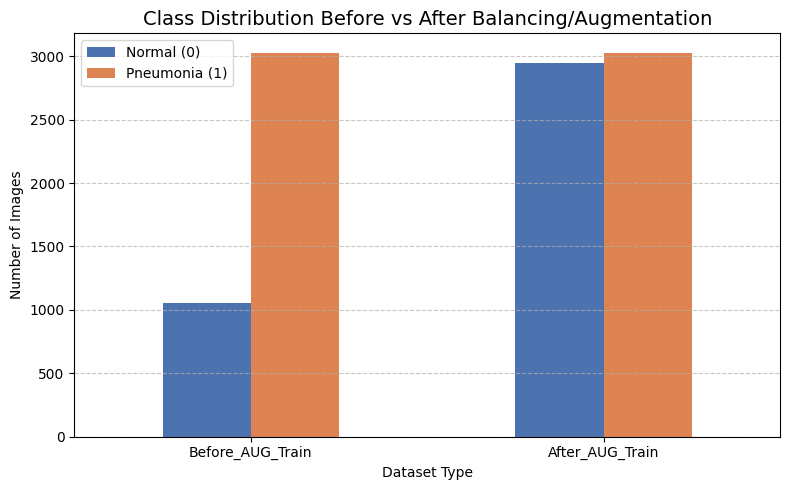

In [14]:
# ---------------- Count before balancing (df_train_new) ----------------
counts_train_before = df_train_new['label'].value_counts().sort_index()

# ---------------- Count after balancing (df_train_balanced) ------------
counts_train_after = df_train_balanced['label'].value_counts().sort_index()

# ---------------- Combine summary table --------------------------------
df_aug_compare = pd.DataFrame({
    'Before_AUG_Train': counts_train_before,
    'After_AUG_Train': counts_train_after
}).T.fillna(0).astype(int)

df_aug_compare['Total'] = df_aug_compare[0] + df_aug_compare[1]

plt.figure(figsize=(8,5))
df_aug_compare[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)

plt.title('Class Distribution Before vs After Balancing/Augmentation', fontsize=14)
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


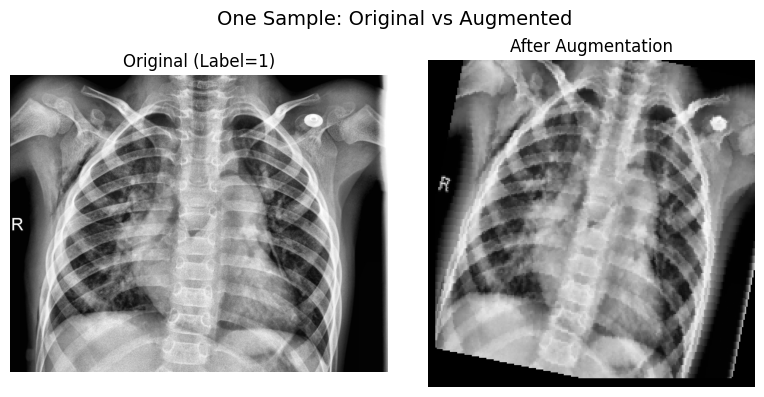

In [15]:
use_rgb = True  
sample = df_train_new.sample(3).iloc[0]
img_path = sample["filepath"]
label = sample["label"]

orig_img = Image.open(img_path)

if use_rgb:
    transform = train_transform_rgb_aug
    mean, std = imagenet_mean, imagenet_std
    orig_img_disp = orig_img.convert("RGB")
else:
    transform = train_transform_gray_aug
    mean, std = [0.5], [0.5]
    orig_img_disp = orig_img.convert("L")

aug_img_tensor = transform(orig_img)
aug_img = aug_img_tensor.clone()

for t, m, s in zip(aug_img, mean, std):
    t.mul_(s).add_(m)
aug_img = torch.clamp(aug_img, 0, 1)
aug_img = aug_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig_img_disp, cmap="gray" if not use_rgb else None)
plt.title(f"Original (Label={label})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img.squeeze(), cmap="gray" if not use_rgb else None)
plt.title("After Augmentation")
plt.axis("off")

plt.suptitle("One Sample: Original vs Augmented", fontsize=14)
plt.tight_layout()
plt.show()


จากภาพด้านซ้ายคือภาพ Original ที่ไม่ได้ Augmentation แล้วทางขวาเป็นภาพที่ถูก Augmentation บีบภาพให้เล็กลงและทำการเอียงภาพเล็กน้อย  

โดยสรุปภาพที่ Augmentation ของ train จากเดิม   
Before: class0=1058, class1=3058, total=4116  
After : class0=3200, class1=3500, total=6700  

## Model config

In [40]:
batch_size = 128

# --- RGB ---
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)

# --- Grayscale ---
train_loader_gray_aug   = DataLoader(train_ds_gray_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_gray_noaug = DataLoader(train_ds_gray_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_gray         = DataLoader(val_ds_gray, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_gray        = DataLoader(test_ds_gray, batch_size=batch_size, shuffle=False, num_workers=0)

## Inference CNN, Resnet50, ViT from trained

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------------
# Evaluation Function (ใช้ได้ทุกโมเดล)
# ----------------------------------------------------------
def evaluate_model(model, test_loader):
    y_true, y_pred, y_prob = [], [], []

    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

    return np.array(y_true), np.array(y_pred), np.array(y_prob)


In [56]:
model_colors = {
    "CNN_Gray_AUG":    "#4C72B0",  # Blue
    "CNN_Gray_NOAUG":  "#55A868",  # Green
    "CNN_RGB_AUG":     "#C44E52",  # Red
    "CNN_RGB_NOAUG":   "#8172B2",  # Purple
    
    # Reserve future (resnet, vit)
    "ResNet_RGB":      "#CCB974",  # Gold
    "ViT_RGB":         "#64B5CD"   # Cyan
}


In [57]:
def plot_confusion_matrix(y_true, y_pred, title, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # ใช้สีประจำโมเดล (light → dark ของสีหลัก)
    base_color = model_colors[model_name]
    cmap = sns.light_palette(base_color, as_cmap=True)

    plt.figure(figsize=(4,3.5))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"])
    plt.title(title, fontsize=12)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc_single(y_true, y_prob, title, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4.5,4))
    plt.plot(fpr, tpr,
             color=model_colors[model_name],
             label=f"AUC={roc_auc:.3f}",
             linewidth=2)
    plt.plot([0,1],[0,1],'k--')
    plt.title(title, fontsize=12)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


In [58]:
class TinyCNN_Gray(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(16*56*56, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)


class TinyCNN_RGB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(16*56*56, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)


In [59]:
models = {
    "CNN_Gray_AUG": {
        "model": TinyCNN_Gray().to(device),
        "ckpt": "best_model_gray_aug.pth",
        "loader": test_loader_gray
    },
    "CNN_Gray_NOAUG": {
        "model": TinyCNN_Gray().to(device),
        "ckpt": "best_model_gray_noaug.pth",
        "loader": test_loader_gray
    },
    "CNN_RGB_AUG": {
        "model": TinyCNN_RGB().to(device),
        "ckpt": "best_model_rgb_aug.pth",
        "loader": test_loader_rgb
    },
    "CNN_RGB_NOAUG": {
        "model": TinyCNN_RGB().to(device),
        "ckpt": "best_model_rgb_noaug.pth",
        "loader": test_loader_rgb
    }
}

# Load all checkpoints
for name, info in models.items():
    ckpt = torch.load(info["ckpt"], map_location=device, weights_only=False)
    info["model"].load_state_dict(ckpt["model_state_dict"])
    print(f"Loaded {name}")


Loaded CNN_Gray_AUG
Loaded CNN_Gray_NOAUG
Loaded CNN_RGB_AUG
Loaded CNN_RGB_NOAUG


In [60]:
results = {}

for name, info in models.items():
    print(f"Evaluating {name} ...")
    y_true, y_pred, y_prob = evaluate_model(info["model"], info["loader"])
    results[name] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob
    }


Evaluating CNN_Gray_AUG ...


Evaluating CNN_Gray_NOAUG ...


Evaluating CNN_RGB_AUG ...


Evaluating CNN_RGB_NOAUG ...



CNN_Gray_AUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.905     0.694     0.786       301
           1      0.856     0.961     0.906       569

    accuracy                          0.869       870
   macro avg      0.880     0.828     0.846       870
weighted avg      0.873     0.869     0.864       870



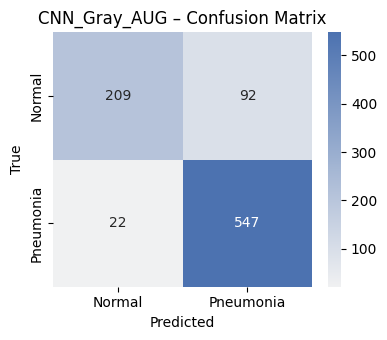

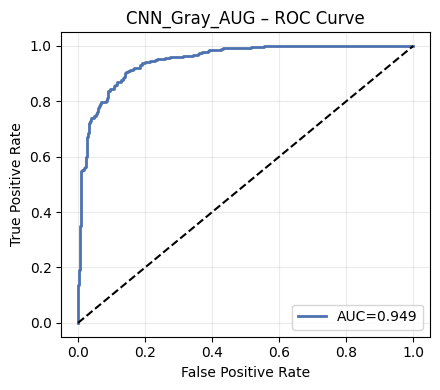


CNN_Gray_NOAUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.963     0.515     0.671       301
           1      0.794     0.989     0.881       569

    accuracy                          0.825       870
   macro avg      0.878     0.752     0.776       870
weighted avg      0.852     0.825     0.808       870



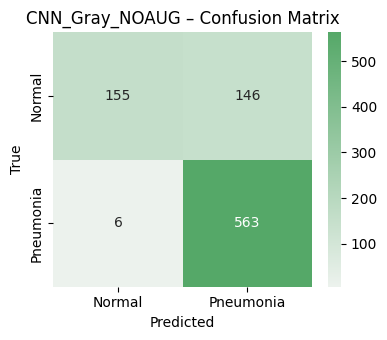

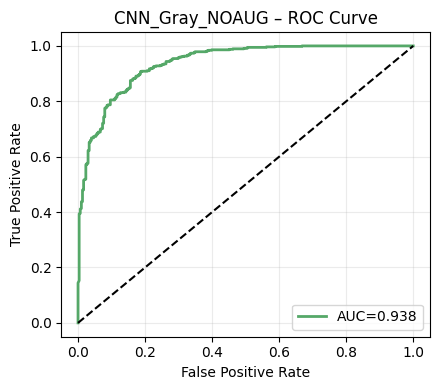


CNN_RGB_AUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.897     0.608     0.725       301
           1      0.823     0.963     0.887       569

    accuracy                          0.840       870
   macro avg      0.860     0.786     0.806       870
weighted avg      0.849     0.840     0.831       870



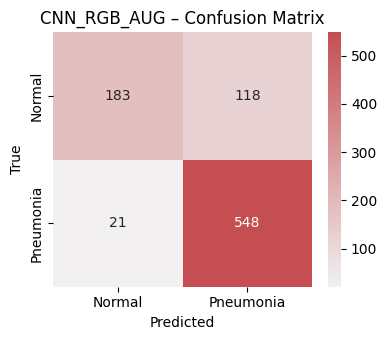

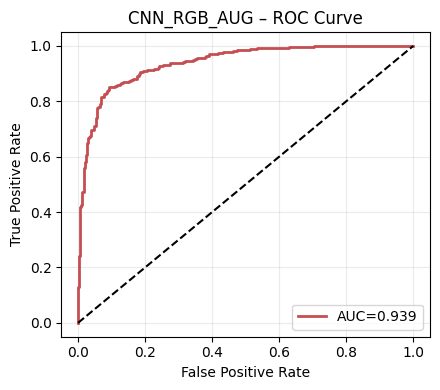


CNN_RGB_NOAUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.960     0.561     0.709       301
           1      0.810     0.988     0.890       569

    accuracy                          0.840       870
   macro avg      0.885     0.775     0.799       870
weighted avg      0.862     0.840     0.827       870



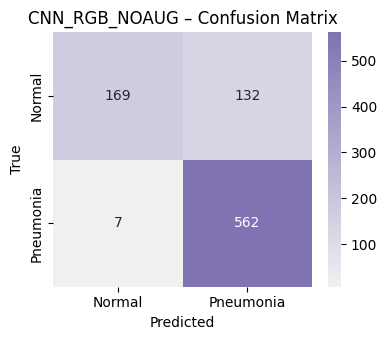

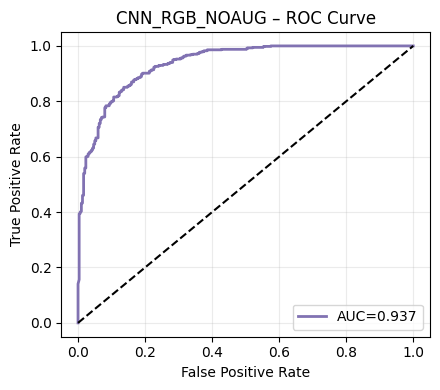

In [61]:
for name, res in results.items():
    print("\n=================================")
    print(f"{name}")
    print("=================================")

    print("\n=== Classification Report ===")
    print(classification_report(res["y_true"], res["y_pred"], digits=3))

    plot_confusion_matrix(res["y_true"], res["y_pred"],
                          f"{name} – Confusion Matrix",
                          model_name=name)

    plot_roc_single(res["y_true"], res["y_prob"],
                    f"{name} – ROC Curve",
                    model_name=name)


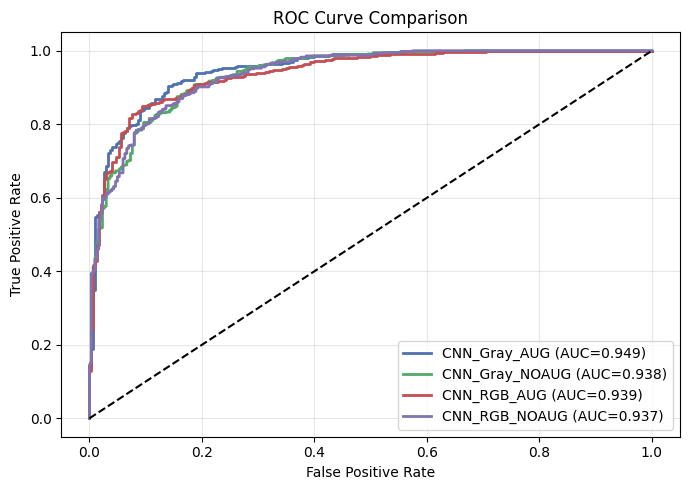

In [62]:
plt.figure(figsize=(7,5))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(res["y_true"], res["y_prob"])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             label=f"{name} (AUC={roc_auc:.3f})",
             color=model_colors[name],
             linewidth=2)

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\eieiz\AppData\Local\Temp\ipykernel_22744\4095167607.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=recall_values, palette=colors)


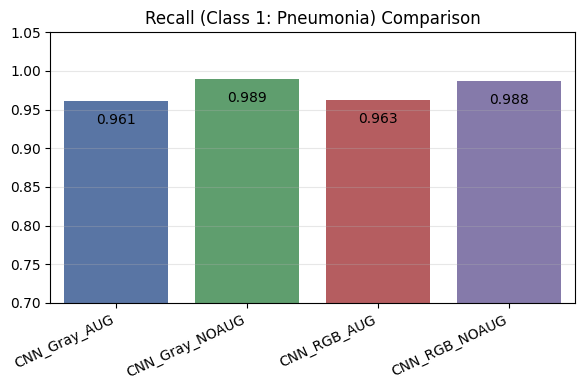

In [63]:
model_names = []
recall_values = []
colors = []

from sklearn.metrics import recall_score

for name, res in results.items():
    model_names.append(name)
    recall_values.append(recall_score(res["y_true"], res["y_pred"], pos_label=1))
    colors.append(model_colors[name])

plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=recall_values, palette=colors)

plt.title("Recall (Class 1: Pneumonia) Comparison", fontsize=12)
plt.ylim(0.7, 1.05)
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)

# numbers on bars
for i, v in enumerate(recall_values):
    plt.text(i, v - 0.03, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()
